In [36]:
# LitSearch RAG Baseline using LangChain with Full Corpus

import pandas as pd
import json
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm  # Using regular tqdm instead of tqdm.notebook
from typing import List, Dict, Any, Union, Optional

# LangChain imports
from langchain.schema import Document
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.retrievers import BM25Retriever
from langchain.retrievers.ensemble import EnsembleRetriever
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate
from langchain.chat_models import ChatOpenAI
from langchain.callbacks import get_openai_callback

# Metrics
from rouge_score import rouge_scorer

# Import for datasets
from datasets import load_dataset

In [ ]:
# Set your OpenAI API key
import os
os.environ["OPENAI_API_KEY"] = "Replace with your API key"  # Replace with your API key
# You can also set it as: os.environ["OPENAI_API_KEY"] = input("Enter your OpenAI API key: ")

# Initialize ROUGE scorer
rouge_scorer_instance = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

In [38]:
## 1. Loading the Datasets

# Function to load user dataset (handles both JSON and CSV)
def load_user_dataset(file_path: str, num_samples: Optional[int] = None):
    """
    Load user dataset from JSON or CSV file
    
    Args:
        file_path: Path to dataset file (JSON or CSV)
        num_samples: Number of samples to use (None = all)
        
    Returns:
        List of dictionaries containing the dataset
    """
    if file_path.endswith('.json'):
        with open(file_path, 'r') as f:
            data = json.load(f)
            dataset = data.get('data', data)  # Handle both {'data': [...]} and direct list format
    elif file_path.endswith('.csv'):
        df = pd.read_csv(file_path)
        dataset = df.to_dict(orient='records')
    else:
        raise ValueError("Unsupported file format. Use JSON or CSV.")
    
    # Sample if requested
    if num_samples and num_samples < len(dataset):
        import random
        random.seed(42)  # For reproducibility
        dataset = random.sample(dataset, num_samples)
    
    print(f"Loaded {len(dataset)} samples from {file_path}")
    return dataset


In [39]:
# Function to load LitSearch corpus from Hugging Face
def load_litsearch_corpus():
    """
    Load the LitSearch corpus from Hugging Face
    
    Returns:
        Dictionary mapping paper IDs to paper content
    """
    print("Loading LitSearch corpus dataset...")
    try:
        # Load the corpus
        corpus_data = load_dataset("princeton-nlp/LitSearch", "corpus_clean", split="full")
        print(f"Loaded {len(corpus_data)} papers from LitSearch corpus")
        
        # Print a sample to understand the structure
        if len(corpus_data) > 0:
            print("Corpus data fields:", list(corpus_data[0].keys()))
        
        # Create a dictionary mapping paper IDs to paper content
        corpus_dict = {}
        paper_id_field = None
        
        # Determine the field containing paper IDs
        if len(corpus_data) > 0:
            sample = corpus_data[0]
            if "paper_id" in sample:
                paper_id_field = "paper_id"
            elif "doc_id" in sample:
                paper_id_field = "doc_id"
            elif "corpusid" in sample:
                paper_id_field = "corpusid"
            else:
                # Find a field that looks like an ID
                for key in sample.keys():
                    if "id" in key.lower():
                        paper_id_field = key
                        break
        
        if not paper_id_field:
            raise ValueError("Could not determine paper ID field in corpus dataset")
        
        print(f"Using '{paper_id_field}' as paper ID field")
        
        # Create the mapping
        for item in tqdm(corpus_data):
            paper_id = item.get(paper_id_field)
            if paper_id:
                corpus_dict[paper_id] = {
                    'title': item.get('title', ''),
                    'abstract': item.get('abstract', ''),
                    'full_text': item.get('full_paper', '')  # Get full paper text if available
                }
        
        print(f"Created corpus dictionary with {len(corpus_dict)} papers")
        return corpus_dict, paper_id_field
    
    except Exception as e:
        print(f"Error loading LitSearch corpus: {e}")
        print("Falling back to using only title and abstract from user dataset")
        return {}, None

# Load your dataset
user_dataset_path = "/Users/himansh/Desktop/ANLP/litsearch/litsearch_rag_dataset_fullpaper_100.json"  # Replace with your path
user_dataset = load_user_dataset(user_dataset_path, num_samples=50)  # Adjust sample size as needed

# Load LitSearch corpus
corpus_dict, paper_id_field = load_litsearch_corpus()

# Display a sample from user dataset
print("\nSample from user dataset:")
print(user_dataset[0])

# Display a sample from corpus (if available)
if corpus_dict:
    print("\nSample from corpus:")
    sample_id = next(iter(corpus_dict))
    print(f"Paper ID: {sample_id}")
    print(f"Title: {corpus_dict[sample_id]['title']}")
    abstract = corpus_dict[sample_id]['abstract']
    print(f"Abstract: {abstract[:200]}...")  # Show just the beginning
    full_text = corpus_dict[sample_id].get('full_text', '')
    if full_text:
        print(f"Full text length: {len(full_text)} characters")
        print(f"Full text sample: {full_text[:200]}...")  # Show just the beginning


Loaded 50 samples from /Users/himansh/Desktop/ANLP/litsearch/litsearch_rag_dataset_fullpaper_100.json
Loading LitSearch corpus dataset...
Loaded 64183 papers from LitSearch corpus
Corpus data fields: ['corpusid', 'title', 'abstract', 'citations', 'full_paper']
Using 'corpusid' as paper ID field


100%|██████████| 64183/64183 [00:11<00:00, 5768.26it/s]

Created corpus dictionary with 64183 papers

Sample from user dataset:
{'original_query': 'Could you suggest research on detecting common errors like additions and omissions in machine translation?', 'paper_title': 'Detecting Over-and Undertranslations with Contrastive Conditioning', 'paper_abstract': 'Omission and addition of content is a typical issue in neural machine translation. We propose a method for detecting such phenomena with off-the-shelf translation models. Using contrastive conditioning, we compare the likelihood of a full sequence under a translation model to the likelihood of its parts, given the corresponding source or target sequence. This allows to pinpoint superfluous words in the translation and untranslated words in the source even in the absence of a reference translation. The accuracy of our method is comparable to a supervised method that requires a custom quality estimation model.', 'used_full_text': True, 'paper_id': 247223093, 'conceptual_question': '"How do

In [40]:
## 2. Preparing Documents for LangChain

def prepare_documents(user_dataset, corpus_dict):
    """
    Convert dataset to LangChain documents format using corpus when available
    """
    langchain_docs = []
    
    # Create a set of all paper IDs in the user dataset
    paper_ids_set = set()
    for item in user_dataset:
        paper_id = item.get('paper_id')
        if paper_id:
            paper_ids_set.add(paper_id)
    
    # Track how many papers have full text
    papers_with_full_text = 0
    papers_with_abstract_only = 0
    
    # Create documents for each paper
    for paper_id in paper_ids_set:
        # Look for the paper in the corpus
        if paper_id in corpus_dict and corpus_dict[paper_id]['full_text']:
            # Use full text from corpus
            paper = corpus_dict[paper_id]
            content = f"Title: {paper['title']}\n\nAbstract: {paper['abstract']}\n\nFull Text: {paper['full_text']}"
            papers_with_full_text += 1
        else:
            # Fallback to using title and abstract from the user dataset
            # Find this paper in the user dataset
            paper_data = next((item for item in user_dataset if item.get('paper_id') == paper_id), None)
            if paper_data:
                title = paper_data.get('paper_title', '')
                abstract = paper_data.get('paper_abstract', '')
                content = f"Title: {title}\n\nAbstract: {abstract}"
                papers_with_abstract_only += 1
            else:
                # Skip if we can't find any information about this paper
                continue
        
        # Create LangChain document
        langchain_docs.append(
            Document(
                page_content=content,
                metadata={
                    'paper_id': paper_id,
                    'source': 'LitSearch'
                }
            )
        )
    
    print(f"Created {len(langchain_docs)} LangChain documents")
    print(f"  - {papers_with_full_text} documents include full text")
    print(f"  - {papers_with_abstract_only} documents include abstract only")
    return langchain_docs

# Create LangChain documents
documents = prepare_documents(user_dataset, corpus_dict)

# Create a lookup dictionary for ground truth papers
ground_truth_lookup = {}
for item in user_dataset:
    question = item.get('conceptual_question')
    if question:
        ground_truth_lookup[question] = {
            'paper_id': item.get('paper_id'),
            'answer': item.get('ground_truth_answer')
        }


Created 50 LangChain documents
  - 50 documents include full text
  - 0 documents include abstract only


In [41]:
## 3. Create Chunker for Longer Documents

# Text splitter for longer documents
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
    length_function=len,
    is_separator_regex=False,
)

# Split documents if they're long
split_docs = text_splitter.split_documents(documents)
print(f"Created {len(split_docs)} chunks from {len(documents)} documents")

Created 4619 chunks from 50 documents


In [ ]:
## 4. Create Retrievers

# 1. BM25 Retriever
bm25_retriever = BM25Retriever.from_documents(split_docs)
bm25_retriever.k = 20  # Top-k documents to retrieve

# 2. Dense Retriever with FAISS
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")
vectorstore = FAISS.from_documents(split_docs, embeddings)
dense_retriever = vectorstore.as_retriever(search_kwargs={"k": 20})

# 3. Ensemble Retriever (combines BM25 and Dense)
ensemble_retriever = EnsembleRetriever(
    retrievers=[bm25_retriever, dense_retriever],
    weights=[0.5, 0.5]
)

In [10]:
## 5. Create RAG Chains with LangChain

# Define a more specific prompt for scientific questions
prompt_template = """You are a helpful scientific assistant. Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.

Context:
{context}

Question: {question}
Answer:"""

PROMPT = PromptTemplate(
    template=prompt_template,
    input_variables=["context", "question"]
)


In [11]:
# Create LLM
llm = ChatOpenAI(temperature=0, model_name="gpt-4o", base_url="https://cmu.litellm.ai")

# Create RetrievalQA chains for each retriever
def create_qa_chain(retriever, llm=llm, prompt=PROMPT):
    return RetrievalQA.from_chain_type(
        llm=llm,
        chain_type="stuff",
        retriever=retriever,
        return_source_documents=True,
        chain_type_kwargs={"prompt": prompt}
    )

# Create the chains
bm25_chain = create_qa_chain(bm25_retriever)
dense_chain = create_qa_chain(dense_retriever)
ensemble_chain = create_qa_chain(ensemble_retriever)

# Zero-shot chain (no retrieval)
zero_shot_template = """You are a helpful scientific assistant with expertise in machine learning, AI, and computer science research. Answer the following question based on your knowledge.

Question: {question}
Answer:"""

ZERO_SHOT_PROMPT = PromptTemplate(
    template=zero_shot_template,
    input_variables=["question"]
)

/var/folders/6z/nz9cvz6s3vg6yvj80zkc7hmm0000gn/T/ipykernel_1837/3920281089.py:2: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(temperature=0, model_name="gpt-4o", base_url="https://cmu.litellm.ai")


In [12]:
## 6. Run Experiments

def evaluate_retrieval(retrieved_docs, ground_truth_paper_id):
    """Evaluate retrieval performance"""
    # Extract paper IDs from chunks
    retrieved_paper_ids = set()
    for doc in retrieved_docs:
        paper_id = doc.metadata.get('paper_id')
        if paper_id:
            retrieved_paper_ids.add(paper_id)
    
    # Convert to list for indexing
    retrieved_paper_ids_list = list(retrieved_paper_ids)
    
    # Check if ground truth is in retrieved docs
    if ground_truth_paper_id in retrieved_paper_ids_list:
        rank = retrieved_paper_ids_list.index(ground_truth_paper_id)
        mrr = 1.0 / (rank + 1)
        found = True
    else:
        mrr = 0.0
        found = False
    
    return {
        "found": found,
        "mrr": mrr,
        "retrieved_paper_ids": retrieved_paper_ids_list
    }

In [ ]:
# Install the required package
# pip install bert-score

from bert_score import score as bert_score

def evaluate_answer(generated, ground_truth):
    """Evaluate answer quality using both ROUGE and BERTScore with SCIBert"""
    # ROUGE scores
    rouge_scores = rouge_scorer_instance.score(ground_truth, generated)
    
    # BERTScore with SCIBert
    P, R, F1 = bert_score(
        [generated], 
        [ground_truth], 
        model_type="allenai/scibert_scivocab_uncased",  # Use SCIBert
        lang="en",
        batch_size=1
    )
    
    return {
        "rouge1": rouge_scores["rouge1"].fmeasure,
        "rouge2": rouge_scores["rouge2"].fmeasure,
        "rougeL": rouge_scores["rougeL"].fmeasure,
        "bertscore_precision": P.item(),
        "bertscore_recall": R.item(),
        "bertscore_f1": F1.item()
    }

In [31]:
def run_experiment(chain, question, ground_truth_info):
    """Run experiment with a specific chain"""
    # Track token usage
    with get_openai_callback() as cb:
        result = chain({"query": question})
    
    # Extract answer and retrieved documents
    answer = result.get("result", "")
    source_docs = result.get("source_documents", [])
    
    # Evaluate retrieval if we have source documents
    retrieval_metrics = {}
    if source_docs:
        retrieval_metrics = evaluate_retrieval(source_docs, ground_truth_info['paper_id'])
    
    # Evaluate answer
    answer_metrics = evaluate_answer(answer, ground_truth_info['answer'])
    
    return {
        "answer": answer,
        "retrieval_metrics": retrieval_metrics,
        "answer_metrics": answer_metrics,
        "token_usage": {
            "prompt_tokens": cb.prompt_tokens,
            "completion_tokens": cb.completion_tokens,
            "total_tokens": cb.total_tokens,
            "cost": cb.total_cost
        }
    }

In [32]:
def run_zero_shot(llm, question, ground_truth_info):
    """Run zero-shot experiment"""
    # Track token usage
    with get_openai_callback() as cb:
        # Format the input properly for a ChatOpenAI model
        formatted_prompt = ZERO_SHOT_PROMPT.format(question=question)
        
        # Use the predict method directly instead of generate
        answer = llm.predict(formatted_prompt)
    
    # Evaluate answer
    answer_metrics = evaluate_answer(answer, ground_truth_info['answer'])
    
    return {
        "answer": answer,
        "answer_metrics": answer_metrics,
        "token_usage": {
            "prompt_tokens": cb.prompt_tokens,
            "completion_tokens": cb.completion_tokens,
            "total_tokens": cb.total_tokens,
            "cost": cb.total_cost
        }
    }

In [33]:
## 7. Run All Baselines

def run_all_baselines(dataset, num_samples=None):
    """Run all baseline methods"""
    if num_samples:
        samples = dataset[:num_samples]
    else:
        samples = dataset
    
    results = {
        "bm25": [],
        "dense": [],
        "ensemble": [],
        "zero_shot": [],
        "summary": {}
    }
    
    print(f"Running baselines on {len(samples)} samples...")
    for i, sample in enumerate(tqdm(samples)):
        question = sample.get('conceptual_question')
        # Skip if question is missing
        if not question:
            continue
            
        # Get ground truth info
        ground_truth_info = ground_truth_lookup.get(question, {})
        if not ground_truth_info:
            print(f"Warning: No ground truth found for question: {question[:50]}...")
            continue
        
        print(f"\nProcessing question {i+1}/{len(samples)}: {question[:100]}...")
        
        # Run BM25 experiment
        print("Running BM25 + LLM...")
        bm25_result = run_experiment(bm25_chain, question, ground_truth_info)
        results["bm25"].append({
            "question": question,
            "ground_truth": ground_truth_info['answer'],
            "answer": bm25_result["answer"],
            "retrieval_metrics": bm25_result["retrieval_metrics"],
            "answer_metrics": bm25_result["answer_metrics"],
            "token_usage": bm25_result["token_usage"]
        })
        
        # Run Dense experiment
        print("Running Dense + LLM...")
        dense_result = run_experiment(dense_chain, question, ground_truth_info)
        results["dense"].append({
            "question": question,
            "ground_truth": ground_truth_info['answer'],
            "answer": dense_result["answer"],
            "retrieval_metrics": dense_result["retrieval_metrics"],
            "answer_metrics": dense_result["answer_metrics"],
            "token_usage": dense_result["token_usage"]
        })
        
        # Run Ensemble experiment
        print("Running Ensemble + LLM...")
        ensemble_result = run_experiment(ensemble_chain, question, ground_truth_info)
        results["ensemble"].append({
            "question": question,
            "ground_truth": ground_truth_info['answer'],
            "answer": ensemble_result["answer"],
            "retrieval_metrics": ensemble_result["retrieval_metrics"],
            "answer_metrics": ensemble_result["answer_metrics"],
            "token_usage": ensemble_result["token_usage"]
        })
        
        # Run Zero-shot experiment
        print("Running Zero-shot...")
        zero_shot_result = run_zero_shot(llm, question, ground_truth_info)
        results["zero_shot"].append({
            "question": question,
            "ground_truth": ground_truth_info['answer'],
            "answer": zero_shot_result["answer"],
            "answer_metrics": zero_shot_result["answer_metrics"],
            "token_usage": zero_shot_result["token_usage"]
        })
    
    # Calculate summary metrics
    calculate_summary_metrics(results)
    
    return results


In [34]:

def calculate_summary_metrics(results):
    """Calculate summary metrics for all methods"""
    methods = ["bm25", "dense", "ensemble", "zero_shot"]
    summary = {}
    
    for method in methods:
        method_results = results[method]
        
        # Skip if no results
        if not method_results:
            continue
            
        method_summary = {
            "answer_metrics": {
                "rouge1": 0.0,
                "rouge2": 0.0,
                "rougeL": 0.0
            }
        }
        
        # Add retrieval metrics for retrieval-based methods
        if method != "zero_shot":
            method_summary["retrieval_metrics"] = {
                "found_rate": 0.0,
                "mrr": 0.0
            }
        
        # Calculate answer metrics
        for result in method_results:
            for metric in method_summary["answer_metrics"]:
                method_summary["answer_metrics"][metric] += result["answer_metrics"][metric]
        
        # Calculate retrieval metrics
        if method != "zero_shot":
            for result in method_results:
                method_summary["retrieval_metrics"]["found_rate"] += 1 if result["retrieval_metrics"].get("found", False) else 0
                method_summary["retrieval_metrics"]["mrr"] += result["retrieval_metrics"].get("mrr", 0.0)
        
        # Calculate averages
        n = len(method_results)
        for metric in method_summary["answer_metrics"]:
            method_summary["answer_metrics"][metric] /= n
        
        if method != "zero_shot":
            for metric in method_summary["retrieval_metrics"]:
                method_summary["retrieval_metrics"][metric] /= n
        
        summary[method] = method_summary
    
    results["summary"] = summary
    return summary


In [35]:
# Run all baselines with a small sample first (adjust as needed)
num_samples = 50  # Start small for testing
results = run_all_baselines(user_dataset, num_samples=num_samples)

## 8. Analyze Results

def print_summary(results):
    """Print summary of results"""
    summary = results["summary"]
    
    print("\nResults Summary:")
    print("===============")
    
    methods = ["bm25", "dense", "ensemble", "zero_shot"]
    for method in methods:
        if method not in summary:
            continue
            
        method_summary = summary[method]
        print(f"\n{method.upper()}:")
        
        # Print retrieval metrics
        if "retrieval_metrics" in method_summary:
            print(f"  Retrieval Success Rate: {method_summary['retrieval_metrics']['found_rate']:.4f}")
            print(f"  MRR: {method_summary['retrieval_metrics']['mrr']:.4f}")
        
        # Print answer metrics
        print(f"  ROUGE-1: {method_summary['answer_metrics']['rouge1']:.4f}")
        print(f"  ROUGE-2: {method_summary['answer_metrics']['rouge2']:.4f}")
        print(f"  ROUGE-L: {method_summary['answer_metrics']['rougeL']:.4f}")

# Print summary
print_summary(results) 


Running baselines on 50 samples...


  0%|          | 0/50 [00:00<?, ?it/s]


Processing question 1/50: "How does the method of contrastive conditioning help in detecting over- and undertranslations in ne...
Running BM25 + LLM...
Running Dense + LLM...
Running Ensemble + LLM...
Running Zero-shot...


  2%|▏         | 1/50 [00:24<20:00, 24.50s/it]


Processing question 2/50: "How does the CoFi method's approach to structured pruning compare to traditional distillation metho...
Running BM25 + LLM...
Running Dense + LLM...
Running Ensemble + LLM...
Running Zero-shot...


  4%|▍         | 2/50 [00:44<17:39, 22.07s/it]


Processing question 3/50: "How does the ConvGQR model improve query reformulation in conversational search, and what are its k...
Running BM25 + LLM...
Running Dense + LLM...
Running Ensemble + LLM...
Running Zero-shot...


  6%|▌         | 3/50 [01:09<18:06, 23.13s/it]


Processing question 4/50: "How does the proposed neural architecture for dialectal Arabic segmentation handle the unique chall...
Running BM25 + LLM...
Running Dense + LLM...
Running Ensemble + LLM...
Running Zero-shot...


  8%|▊         | 4/50 [01:24<15:28, 20.18s/it]


Processing question 5/50: "How does the SALMON approach facilitate AI alignment with minimal human supervision, and how does i...
Running BM25 + LLM...
Running Dense + LLM...
Running Ensemble + LLM...
Running Zero-shot...


 10%|█         | 5/50 [01:45<15:09, 20.22s/it]


Processing question 6/50: "What is the COVID-19-Stance dataset, and how does it contribute to research in stance detection reg...
Running BM25 + LLM...
Running Dense + LLM...
Running Ensemble + LLM...
Running Zero-shot...


 12%|█▏        | 6/50 [02:07<15:17, 20.84s/it]


Processing question 7/50: "How does Pattern-Exploiting Training (PET) improve performance in few-shot text classification and ...
Running BM25 + LLM...
Running Dense + LLM...
Running Ensemble + LLM...
Running Zero-shot...


 14%|█▍        | 7/50 [02:29<15:13, 21.24s/it]


Processing question 8/50: "What methodologies and evaluation metrics were employed in the Semantic Role Labeling subtask of Se...
Running BM25 + LLM...
Running Dense + LLM...
Running Ensemble + LLM...
Running Zero-shot...


 16%|█▌        | 8/50 [02:57<16:27, 23.51s/it]


Processing question 9/50: "How does the ALIGNSCORE metric utilize a mean-max aggregation approach to evaluate factual consiste...
Running BM25 + LLM...
Running Dense + LLM...
Running Ensemble + LLM...
Running Zero-shot...


 18%|█▊        | 9/50 [03:21<16:13, 23.75s/it]


Processing question 10/50: "What are the key findings of the paper 'Distill or Annotate? Cost-Efficient Fine-Tuning of Compact ...
Running BM25 + LLM...
Running Dense + LLM...
Running Ensemble + LLM...
Running Zero-shot...


 20%|██        | 10/50 [03:40<14:49, 22.23s/it]


Processing question 11/50: "How does the Neural Path Hunter (NPH) method reduce hallucinations in dialogue systems using knowle...
Running BM25 + LLM...
Running Dense + LLM...
Running Ensemble + LLM...
Running Zero-shot...


 22%|██▏       | 11/50 [03:58<13:37, 20.97s/it]


Processing question 12/50: "How does the MultiTACRED dataset enhance multilingual relation extraction, and what are the main ch...
Running BM25 + LLM...
Running Dense + LLM...
Running Ensemble + LLM...
Running Zero-shot...


 24%|██▍       | 12/50 [04:26<14:29, 22.88s/it]


Processing question 13/50: "How does the Basis-Aware Threshold (BAT) sampling method proposed in the paper address the softmax ...
Running BM25 + LLM...
Running Dense + LLM...
Running Ensemble + LLM...
Running Zero-shot...


 26%|██▌       | 13/50 [04:44<13:12, 21.41s/it]


Processing question 14/50: "What methods and datasets were used in the iSarcasmEval shared task for detecting intended sarcasm ...
Running BM25 + LLM...
Running Dense + LLM...
Running Ensemble + LLM...
Running Zero-shot...


 28%|██▊       | 14/50 [05:08<13:20, 22.24s/it]


Processing question 15/50: "What are the unique features and challenges of the MAD-TSC dataset in performing target-dependent s...
Running BM25 + LLM...
Running Dense + LLM...
Running Ensemble + LLM...
Running Zero-shot...


 30%|███       | 15/50 [05:33<13:26, 23.05s/it]


Processing question 16/50: "How do neurons in a two-layer ReLU network with small initialization achieve alignment during train...
Running BM25 + LLM...
Running Dense + LLM...
Running Ensemble + LLM...
Running Zero-shot...


 32%|███▏      | 16/50 [05:59<13:31, 23.87s/it]


Processing question 17/50: "How does the CRONQUESTIONS dataset facilitate progress in Temporal Knowledge Graph Question Answeri...
Running BM25 + LLM...
Running Dense + LLM...
Running Ensemble + LLM...
Running Zero-shot...


 34%|███▍      | 17/50 [06:21<12:57, 23.55s/it]


Processing question 18/50: "What are the key contributions of the XLM-R model in multilingual representation learning and how d...
Running BM25 + LLM...
Running Dense + LLM...
Running Ensemble + LLM...
Running Zero-shot...


 36%|███▌      | 18/50 [06:59<14:50, 27.83s/it]


Processing question 19/50: "How does the CALOR corpus facilitate semantic frame parsing for information extraction, and what ar...
Running BM25 + LLM...
Running Dense + LLM...
Running Ensemble + LLM...
Running Zero-shot...


 38%|███▊      | 19/50 [07:23<13:45, 26.64s/it]


Processing question 20/50: "How does the DGSlow method utilize multi-objective optimization to create effective adversarial att...
Running BM25 + LLM...
Running Dense + LLM...
Running Ensemble + LLM...
Running Zero-shot...


 40%|████      | 20/50 [07:45<12:34, 25.16s/it]


Processing question 21/50: "How does the DCLR framework address the issues of false negatives and sampling bias in unsupervised...
Running BM25 + LLM...
Running Dense + LLM...
Running Ensemble + LLM...
Running Zero-shot...


 42%|████▏     | 21/50 [08:07<11:42, 24.24s/it]


Processing question 22/50: "How does the scalability of pre-trained language models impact the efficacy of prompt tuning compar...
Running BM25 + LLM...
Running Dense + LLM...
Running Ensemble + LLM...
Running Zero-shot...


 44%|████▍     | 22/50 [08:36<12:02, 25.79s/it]


Processing question 23/50: "How does the PAED model address the challenges of zero-shot persona attribute extraction in dialogu...
Running BM25 + LLM...
Running Dense + LLM...
Running Ensemble + LLM...
Running Zero-shot...


 46%|████▌     | 23/50 [09:07<12:17, 27.30s/it]


Processing question 24/50: "How can gaze fixation patterns reveal a reader's native language when reading in English, and what ...
Running BM25 + LLM...
Running Dense + LLM...
Running Ensemble + LLM...
Running Zero-shot...


 48%|████▊     | 24/50 [09:27<10:51, 25.04s/it]


Processing question 25/50: "How can the Universal Joy dataset be used to improve emotion classification across multiple languag...
Running BM25 + LLM...
Running Dense + LLM...
Running Ensemble + LLM...
Running Zero-shot...


 50%|█████     | 25/50 [09:51<10:18, 24.75s/it]


Processing question 26/50: "How does the integration of concept co-occurrence graphs and pretrained language models facilitate ...
Running BM25 + LLM...
Running Dense + LLM...
Running Ensemble + LLM...
Running Zero-shot...


 52%|█████▏    | 26/50 [10:35<12:10, 30.44s/it]


Processing question 27/50: "How does the QuestEval metric improve the evaluation of summarization accuracy and align with human...
Running BM25 + LLM...
Running Dense + LLM...
Running Ensemble + LLM...
Running Zero-shot...


 54%|█████▍    | 27/50 [10:59<10:59, 28.68s/it]


Processing question 28/50: "How does linear decomposition help interpret Transformer models, particularly in identifying source...
Running BM25 + LLM...
Running Dense + LLM...
Running Ensemble + LLM...
Running Zero-shot...


 56%|█████▌    | 28/50 [11:24<10:07, 27.60s/it]


Processing question 29/50: "How does LayoutMask improve text-layout interactions in multi-modal document pre-training, and what...
Running BM25 + LLM...
Running Dense + LLM...
Running Ensemble + LLM...
Running Zero-shot...


 58%|█████▊    | 29/50 [11:44<08:50, 25.25s/it]


Processing question 30/50: "How does the KILT benchmark facilitate research on knowledge-intensive language tasks, and what are...
Running BM25 + LLM...
Running Dense + LLM...
Running Ensemble + LLM...
Running Zero-shot...


 60%|██████    | 30/50 [12:06<08:03, 24.16s/it]


Processing question 31/50: "How do language models compare to humans in interpreting non-literal language phenomena such as iro...
Running BM25 + LLM...
Running Dense + LLM...
Running Ensemble + LLM...
Running Zero-shot...


 62%|██████▏   | 31/50 [12:43<08:56, 28.24s/it]


Processing question 32/50: "How does the in-sample curriculum learning (ICL) strategy improve the performance of natural langua...
Running BM25 + LLM...
Running Dense + LLM...
Running Ensemble + LLM...
Running Zero-shot...


 64%|██████▍   | 32/50 [13:31<10:11, 34.00s/it]


Processing question 33/50: "What are the main challenges and solutions proposed for improving annotation quality in cross-lingu...
Running BM25 + LLM...
Running Dense + LLM...
Running Ensemble + LLM...
Running Zero-shot...


 66%|██████▌   | 33/50 [13:58<09:04, 32.06s/it]


Processing question 34/50: "How does the order of in-context examples affect the performance of language models, and what metho...
Running BM25 + LLM...
Running Dense + LLM...
Running Ensemble + LLM...
Running Zero-shot...


 68%|██████▊   | 34/50 [14:21<07:49, 29.32s/it]


Processing question 35/50: "How does the multi-dialect neural machine translation model for Japanese improve translation accura...
Running BM25 + LLM...
Running Dense + LLM...
Running Ensemble + LLM...
Running Zero-shot...


 70%|███████   | 35/50 [14:49<07:11, 28.73s/it]


Processing question 36/50: "How does incorporating distribution-balanced loss functions improve multi-label text classification...
Running BM25 + LLM...
Running Dense + LLM...
Running Ensemble + LLM...
Running Zero-shot...


 72%|███████▏  | 36/50 [15:24<07:10, 30.74s/it]


Processing question 37/50: "How does the classifier-based parser described in the paper handle the transformation and detransfo...
Running BM25 + LLM...
Running Dense + LLM...
Running Ensemble + LLM...
Running Zero-shot...


 74%|███████▍  | 37/50 [15:49<06:17, 29.01s/it]


Processing question 38/50: "What challenges do large language models face in being evaluated accurately for open-domain questio...
Running BM25 + LLM...
Running Dense + LLM...
Running Ensemble + LLM...
Running Zero-shot...


 76%|███████▌  | 38/50 [16:21<05:59, 29.95s/it]


Processing question 39/50: "How does the ULTRA approach enable zero-shot and fine-tuned knowledge graph reasoning with unseen e...
Running BM25 + LLM...
Running Dense + LLM...
Running Ensemble + LLM...
Running Zero-shot...


 78%|███████▊  | 39/50 [16:48<05:19, 29.08s/it]


Processing question 40/50: "How do factual and contextual error types differ in language models when generating descriptions fo...
Running BM25 + LLM...
Running Dense + LLM...
Running Ensemble + LLM...
Running Zero-shot...


 80%|████████  | 40/50 [17:12<04:35, 27.59s/it]


Processing question 41/50: "How does the SDP-LSTM model utilize shortest dependency paths and LSTM networks to improve relation...
Running BM25 + LLM...
Running Dense + LLM...
Running Ensemble + LLM...
Running Zero-shot...


 82%|████████▏ | 41/50 [18:09<05:26, 36.22s/it]


Processing question 42/50: "How does the Geometric Transform Attention (GTA) mechanism improve the handling of positional encod...
Running BM25 + LLM...
Running Dense + LLM...
Running Ensemble + LLM...
Running Zero-shot...


 84%|████████▍ | 42/50 [19:07<05:41, 42.71s/it]


Processing question 43/50: "What are the main challenges faced by open-domain question answering models when dealing with quest...
Running BM25 + LLM...
Running Dense + LLM...
Running Ensemble + LLM...
Running Zero-shot...


 86%|████████▌ | 43/50 [19:32<04:23, 37.58s/it]


Processing question 44/50: "What is the Target-Stance Extraction (TSE) task proposed in stance detection, and how does it diffe...
Running BM25 + LLM...
Running Dense + LLM...
Running Ensemble + LLM...
Running Zero-shot...


 88%|████████▊ | 44/50 [19:55<03:19, 33.18s/it]


Processing question 45/50: "How does the human-in-the-loop evaluation framework enhance the detection of novel misinformation c...
Running BM25 + LLM...
Running Dense + LLM...
Running Ensemble + LLM...
Running Zero-shot...


 90%|█████████ | 45/50 [20:22<02:36, 31.31s/it]


Processing question 46/50: "How does the mT5 model achieve state-of-the-art performance in multilingual NLP tasks, and what are...
Running BM25 + LLM...
Running Dense + LLM...
Running Ensemble + LLM...
Running Zero-shot...


 92%|█████████▏| 46/50 [20:55<02:06, 31.71s/it]


Processing question 47/50: "How does the unified segmentation model for Arabic dialects discussed in 'Learning from Relatives: ...
Running BM25 + LLM...
Running Dense + LLM...
Running Ensemble + LLM...
Running Zero-shot...


 94%|█████████▍| 47/50 [21:19<01:28, 29.63s/it]


Processing question 48/50: "How does the multi-task based approach to annotator disagreement, as explored in the paper 'Dealing...
Running BM25 + LLM...
Running Dense + LLM...
Running Ensemble + LLM...
Running Zero-shot...


 96%|█████████▌| 48/50 [21:47<00:57, 28.85s/it]


Processing question 49/50: "How does instruction tuning affect the scalability and performance of Mixture-of-Experts models com...
Running BM25 + LLM...
Running Dense + LLM...
Running Ensemble + LLM...
Running Zero-shot...


 98%|█████████▊| 49/50 [22:11<00:27, 27.48s/it]


Processing question 50/50: "How does the PuMer framework improve inference speed and memory efficiency in large-scale Vision La...
Running BM25 + LLM...
Running Dense + LLM...
Running Ensemble + LLM...
Running Zero-shot...


100%|██████████| 50/50 [22:32<00:00, 27.05s/it]


Results Summary:

BM25:
  Retrieval Success Rate: 0.9800
  MRR: 0.9367
  ROUGE-1: 0.4489
  ROUGE-2: 0.1865
  ROUGE-L: 0.2547

DENSE:
  Retrieval Success Rate: 1.0000
  MRR: 0.9600
  ROUGE-1: 0.4166
  ROUGE-2: 0.1703
  ROUGE-L: 0.2345

ENSEMBLE:
  Retrieval Success Rate: 1.0000
  MRR: 0.9133
  ROUGE-1: 0.4841
  ROUGE-2: 0.2012
  ROUGE-L: 0.2695

ZERO_SHOT:
  ROUGE-1: 0.4814
  ROUGE-2: 0.1398
  ROUGE-L: 0.2169


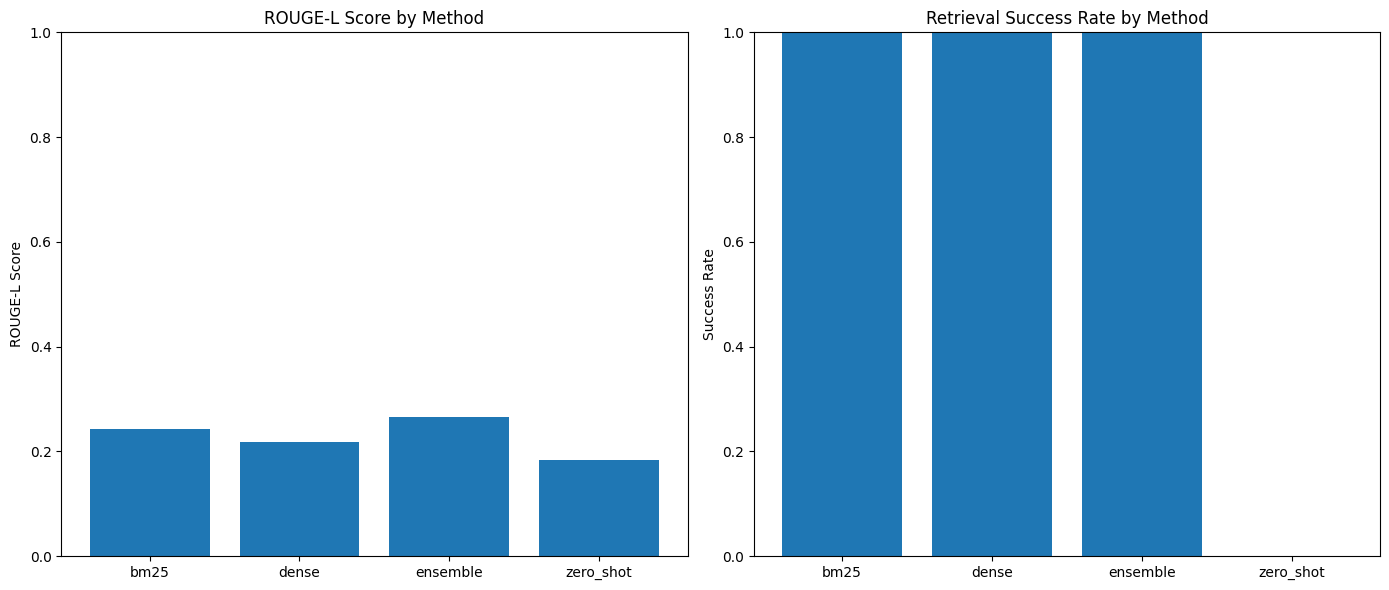

In [21]:
## 9. Visualize Results

def plot_results(results):
    """Plot comparison of different methods"""
    summary = results["summary"]
    methods = ["bm25", "dense", "ensemble", "zero_shot"]
    
    # Filter methods that have results
    methods = [method for method in methods if method in summary]
    
    # Get ROUGE-L scores
    rouge_l_scores = [summary[method]["answer_metrics"]["rougeL"] for method in methods]
    
    # Get retrieval success rates
    retrieval_rates = []
    for method in methods:
        if "retrieval_metrics" in summary[method]:
            retrieval_rates.append(summary[method]["retrieval_metrics"]["found_rate"])
        else:
            retrieval_rates.append(0)  # Zero-shot has no retrieval
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot ROUGE-L scores
    ax1.bar(methods, rouge_l_scores)
    ax1.set_title('ROUGE-L Score by Method')
    ax1.set_ylabel('ROUGE-L Score')
    ax1.set_ylim(0, 1)
    
    # Plot retrieval success rates
    ax2.bar(methods, retrieval_rates)
    ax2.set_title('Retrieval Success Rate by Method')
    ax2.set_ylabel('Success Rate')
    ax2.set_ylim(0, 1)
    
    plt.tight_layout()
    plt.show()

# Plot results
plot_results(results)

In [22]:
## 10. Save Results

def save_results(results, output_file="langchain_rag_results.json"):
    """Save results to JSON file"""
    # Convert numpy values to Python types for JSON serialization
    def convert_for_json(obj):
        if isinstance(obj, np.float32) or isinstance(obj, np.float64):
            return float(obj)
        elif isinstance(obj, np.int32) or isinstance(obj, np.int64):
            return int(obj)
        elif isinstance(obj, list):
            return [convert_for_json(item) for item in obj]
        elif isinstance(obj, dict):
            return {key: convert_for_json(value) for key, value in obj.items()}
        else:
            return obj
    
    converted_results = convert_for_json(results)
    
    with open(output_file, 'w') as f:
        json.dump(converted_results, f, indent=2)
    
    print(f"Results saved to {output_file}")

# Save results
save_results(results)

Results saved to langchain_rag_results.json
